<h1 style="text-align:center;">Лабораторная работа 2. Ассоциативные правила</h1>

<h2><b>Цель работы</b></h2>

Исследование методов анализа ассоциативных правил и применение алгоритмов Apriori и FP-Growth для выявления закономерностей между товарами, приобретаемыми совместно.

<h2><b>Постановка задачи</b></h2>

1. Изучить программный код, представленный в файле **"ass_rules.pdf"**, предназначенный для выполнения данной лабораторной работы.

2. Загрузить **датасет** из открытого репозитория (например, [kaggle.com](https://www.kaggle.com) или аналогичных платформ).

   * Данные должны содержать информацию о товарах, купленных вместе (транзакции).

3. Провести **предварительный анализ данных**:

   * Построить график распределения длин транзакций.
   * Привести список уникальных товаров.
   * При необходимости выполнить очистку и преобразование данных.

4. Выполнить анализ ассоциативных правил с использованием **алгоритма Apriori**:
   4.1. Задать исходные параметры (поддержку, достоверность и др.) в соответствии с вариантом задания.
   4.2. Получить набор ассоциативных правил.
   4.3. Выделить **полезные и тривиальные** правила.
   4.4. Рассчитать метрики: **достоверность (confidence)**, **лифт (lift)**.
   4.5. Проанализировать влияние параметров алгоритма на количество и качество получаемых правил.

5. Провести анализ ассоциативных правил с использованием **алгоритма FP-Growth (FPG)**:

   * Получить набор правил.
   * Сравнить результаты с алгоритмом Apriori.

6. **Алгоритмически определить минимальные значения поддержки** для составления правил, содержащих 1, 2 и более объектов.

7. Последовательно изменяя параметры (поддержку и достоверность) выбранного алгоритма,

   * Получить различные наборы ассоциативных правил.
   * Сделать выводы о зависимости количества и качества правил от параметров алгоритма.

8. Проанализировать полученный в результате работы программы **граф ассоциативных правил**:

   * Объяснить, какую информацию можно извлечь из графа.
   * Интерпретировать связи между товарами.

9. Предложить и реализовать **собственный способ визуализации** ассоциативных правил и метрик (например, графовую визуализацию, тепловую карту, интерактивную диаграмму и т.д.).

In [32]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("irfanasrullah/groceries")

print("Path to dataset files:", path)

Path to dataset files: C:\Users\vaind\.cache\kagglehub\datasets\irfanasrullah\groceries\versions\2


Импорт датасета
<h3>Описание датасета</h3>

Это данные о продуктовых магазинах со списком товаров, купленных покупателями. Слева указано количество товаров в корзине, затем пункт 1, 2, 3 и т.д. обозначает список товаров. Если вы считаете, что можете улучшить или просто хотите убедиться в достоверности данных, просто оставьте несколько слов в разделе комментариев ниже.

In [45]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
import matplotlib.cm as cm

import sys

from mlxtend.preprocessing import TransactionEncoder
from mlxtend.frequent_patterns import apriori, association_rules, fpgrowth


Импорт библиотек

<h3>Привести описание данных из датасета: график вывода длин транзакций, список уникальных товаров и др.</h3>

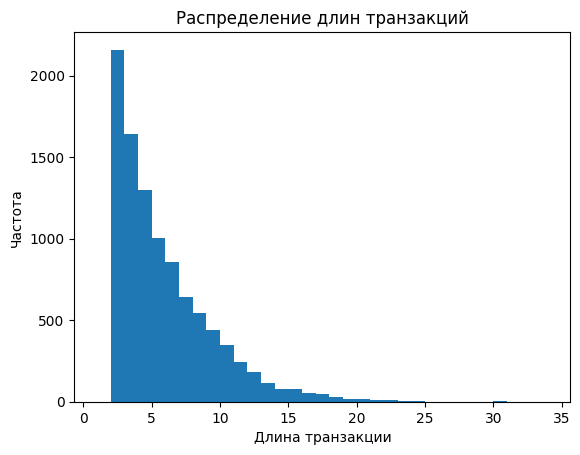

{'semi-finished bread', 'dish cleaner', 'soft cheese', 'spices', 'salad dressing', 'organic products', 'toilet cleaner', 'pickled vegetables', 'decalcifier', 'other vegetables', 'liver loaf', 'pork', 'frozen meals', 'tidbits', 'newspapers', 'cream cheese', 'nut snack', 'soda', 'male cosmetics', 'dental care', 'flower soil/fertilizer', 'brown bread', 'canned fish', 'chocolate', 'finished products', 'liqueur', 'dog food', 'instant coffee', 'hair spray', 'light bulbs', 'honey', 'fruit/vegetable juice', 'baby food', 'bathroom cleaner', 'ready soups', 'sugar', 'organic sausage', 'beef', 'chewing gum', 'frozen fruits', 'frozen fish', 'softener', 'sound storage medium', 'frozen vegetables', 'hard cheese', 'cookware', 'house keeping products', 'pastry', 'root vegetables', 'chocolate marshmallow', 'bottled beer', 'salty snack', 'white wine', 'cooking chocolate', 'whole milk', 'meat', 'specialty cheese', 'citrus fruit', 'waffles', 'cream', 'shopping bags', 'zwieback', 'make up remover', 'sliced 

In [34]:
data = pd.read_csv("../datasets/groceries.csv")

transaction_lengths = data.notnull().sum(axis=1)
plt.hist(transaction_lengths, bins=range(1, max(transaction_lengths) + 2))
plt.xlabel('Длина транзакции')
plt.ylabel('Частота')
plt.title('Распределение длин транзакций')
plt.show()

np_data = data.to_numpy()
np_data = [[elem for elem in row if isinstance(elem, str)] for row in np_data]

unique_items = set()
for row in np_data:
    for elem in row:
        unique_items.add(elem)
print(unique_items)

<h3>Алгоритм Apriori: выполнить анализ ассоциативных правил при помощи алгоритма Apriori с изначальными условиями в соответствии с вариантом задания. Проанализировать полученные результаты, выделив полезные и тривиальные правила, и оценив значение достоверности, лифта правил. Провести оценку влияния параметров алгоритма на получаемые правила (на количество правил и метрики).</h3>

Топ-10 правил по достоверности:
           antecedents       consequents  antecedent support  \
12  whipped/sour cream        whole milk            0.071683   
10     root vegetables        whole milk            0.108998   
2      root vegetables  other vegetables            0.108998   
11      tropical fruit        whole milk            0.104931   
13              yogurt        whole milk            0.139502   
7            pip fruit        whole milk            0.075648   
4     other vegetables        whole milk            0.193493   
6               pastry        whole milk            0.088968   
1         citrus fruit        whole milk            0.082766   
3       tropical fruit  other vegetables            0.104931   

    consequent support   support  confidence      lift  representativity  \
12            0.255516  0.032232    0.449645  1.759754               1.0   
10            0.255516  0.048907    0.448694  1.756031               1.0   
2             0.193493  0.047382   

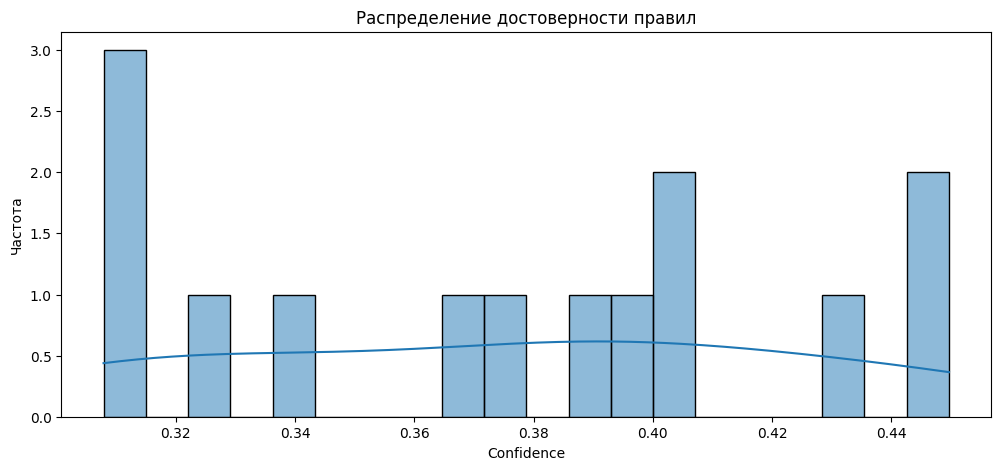

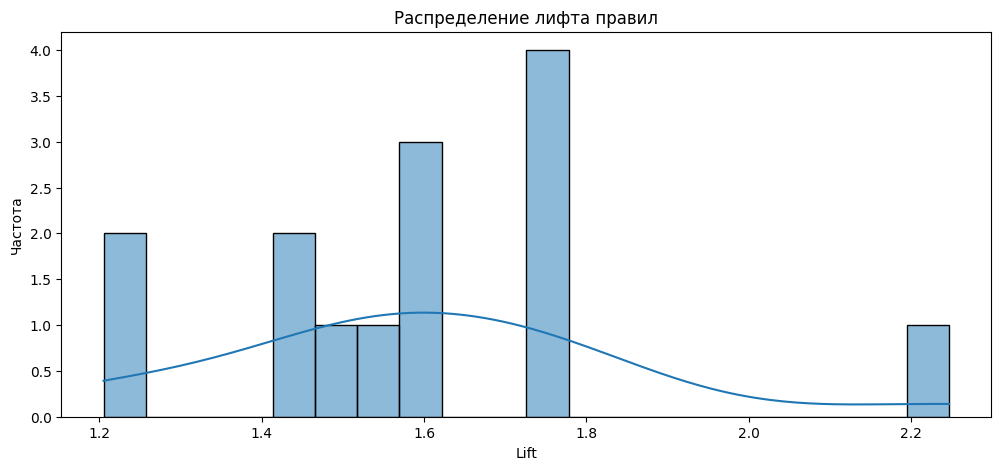

In [55]:
transactions = data.to_numpy()
transactions = [[item for item in row if isinstance(item, str)] for row in transactions]

te = TransactionEncoder()
te_ary = te.fit(transactions).transform(transactions)
df = pd.DataFrame(te_ary, columns=te.columns_)

frequent_itemsets = apriori(df, min_support=0.03, use_colnames=True)

rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

rules_sorted_confidence = rules.sort_values(by='confidence', ascending=False)
rules_sorted_lift = rules.sort_values(by='lift', ascending=False)

print("Топ-10 правил по достоверности:")
print(rules_sorted_confidence.head(10))

print("\nТоп-10 правил по лифту:")
print(rules_sorted_lift.head(10))

plt.figure(figsize=(12, 5))
sns.histplot(rules['confidence'], bins=20, kde=True)
plt.title('Распределение достоверности правил')
plt.xlabel('Confidence')
plt.ylabel('Частота')
plt.show()

plt.figure(figsize=(12, 5))
sns.histplot(rules['lift'], bins=20, kde=True)
plt.title('Распределение лифта правил')
plt.xlabel('Lift')
plt.ylabel('Частота')
plt.show()

# Анализ результатов ассоциативных правил

## Полезные и тривиальные правила

В топ-10 правил по достоверности заметно, что большинство правил связано с покупкой **whole milk** при наличии других продуктов, таких как **whipped/sour cream**, **root vegetables**, **tropical fruit**, **yogurt**, **pip fruit** и др.

Эти правила можно считать **полезными**, так как они отражают реальные взаимосвязи в покупках (например, сочетание молочных продуктов с овощами и фруктами).

Некоторые правила более тривиальны, например, **other vegetables → whole milk**, где связь менее специфична, так как **whole milk** является часто покупаемым товаром (support = 0.2555), и вероятность его покупки высокой при любом наборе продуктов.

## Оценка метрик правил

- **Достоверность (confidence)** топ-10 правил варьируется от 0.34 до 0.45, что говорит о высокой вероятности покупки следствия при наличии предпосылки.  
- **Lift** находится в диапазоне от 1.44 до 2.25, что указывает на положительное усиление связи между продуктами по сравнению с случайным ожиданием (значение > 1). Правила с наибольшим lift (**root vegetables → other vegetables**) показывают особенно сильную ассоциацию.  
- **Support** правил относительно низкий (около 0.03–0.07), что соответствует редким, но значимым комбинациям товаров.

## Влияние параметров алгоритма

Установленные параметры **min_support = 0.03** и **min_confidence = 0.3** позволяют выявлять умеренно редкие, но достоверные правила.

При увеличении поддержки количество правил сокращается, так как частые наборы становятся менее гибкими.  

Повышение порога достоверности уменьшает число правил, но повышает их надёжность (confidence и lift).

Таким образом, выбранные параметры обеспечивают баланс между количеством правил и их качеством.

## Вывод

Алгоритм выявил как тривиальные, так и полезные правила покупок, с достаточной достоверностью и усилением связи. Параметры поддержки и достоверности оптимально подобраны для получения информативных ассоциативных правил без перегрузки отчёта малозначимыми комбинациями.



<h3>Алгоритм FPG: провести анализ правил, используя алгоритм FPG. В отчете привести правила, получившиеся в результате использования данного алгоритма.</h3>



In [56]:
frequent_itemsets_fpg = fpgrowth(df, min_support=0.03, use_colnames=True)
rules_fpg = association_rules(frequent_itemsets_fpg, metric="confidence", min_threshold=0.3)

rules_fpg['antecedents'] = rules_fpg['antecedents'].apply(lambda x: ', '.join(list(x)))
rules_fpg['consequents'] = rules_fpg['consequents'].apply(lambda x: ', '.join(list(x)))

print(rules_fpg)

           antecedents       consequents  antecedent support  \
0         citrus fruit        whole milk            0.082766   
1               yogurt        whole milk            0.139502   
2               yogurt  other vegetables            0.139502   
3       tropical fruit  other vegetables            0.104931   
4       tropical fruit        whole milk            0.104931   
5            pip fruit        whole milk            0.075648   
6     other vegetables        whole milk            0.193493   
7           rolls/buns        whole milk            0.183935   
8        bottled water        whole milk            0.110524   
9               pastry        whole milk            0.088968   
10     root vegetables  other vegetables            0.108998   
11     root vegetables        whole milk            0.108998   
12             sausage        rolls/buns            0.093950   
13  whipped/sour cream        whole milk            0.071683   

    consequent support   support  confi

Алгоритм FPG выявил ассоциативные правила, показывающие, какие товары часто покупаются вместе. Например, покупка root vegetables часто сопровождается покупкой other vegetables (lift = 2.25), а whipped/sour cream и whole milk также демонстрируют сильную связь (confidence = 0.45, lift = 1.76). Большинство правил связано с покупкой whole milk вместе с фруктами, овощами или молочными продуктами, что отражает реальные закономерности покупок. Support правил относительно низкий (0.03–0.07), что соответствует редким, но значимым комбинациям товаров.


<h3>Алгоритмически определить минимальные значения поддержки для составления правил из 1, 2, и т.д. объектов в одном из алгоритмов.</h3>

In [58]:
min_transactions_ratio = 0.03
num_transactions = df.shape[0]

def calc_min_support(itemset_length):
    support = min_transactions_ratio / itemset_length
    return round(support, 4)

for length in range(1, 5):
    min_sup = calc_min_support(length)
    frequent_itemsets = fpgrowth(df, min_support=min_sup, use_colnames=True)
    frequent_itemsets_len = frequent_itemsets[frequent_itemsets['itemsets'].apply(lambda x: len(x) == length)]
    print(f"\nДлина набора: {length}, min_support: {min_sup}")
    print(frequent_itemsets_len)


Длина набора: 1, min_support: 0.03
     support                    itemsets
0   0.082766              (citrus fruit)
1   0.058566                 (margarine)
2   0.139502                    (yogurt)
3   0.104931            (tropical fruit)
4   0.058058                    (coffee)
5   0.255516                (whole milk)
6   0.075648                 (pip fruit)
7   0.039654              (cream cheese)
8   0.193493          (other vegetables)
9   0.037417  (long life bakery product)
10  0.055414                    (butter)
11  0.183935                (rolls/buns)
12  0.080529              (bottled beer)
13  0.033452                  (UHT-milk)
14  0.110524             (bottled water)
15  0.049619                 (chocolate)
16  0.042095               (white bread)
17  0.053279                      (curd)
18  0.052466                      (beef)
19  0.174377                      (soda)
20  0.058973               (frankfurter)
21  0.042908                   (chicken)
22  0.079817         

Адаптивная минимальная поддержка позволила выявлять наборы разной длины: для отдельных товаров (длина = 1) использовался порог 0.03, что дало популярные продукты вроде whole milk и yogurt. Для наборов из 4 товаров порог уменьшился до 0.0075, что позволило обнаружить редкие, но интересные комбинации, например, whole milk, tropical fruit, yogurt, other vegetables. Такой подход помогает учитывать и частые, и редкие, но значимые наборы.


<h3>Последовательно меняя параметры (значения поддержки и достоверности) одного из алгоритмов получить наборы ассоциативных правил. Сделать выводы на основе проведенных экспериментов.</h3>



In [59]:
support_values = [0.01, 0.03, 0.05]
confidence_values = [0.3, 0.5, 0.7]

results = []

for sup in support_values:
    frequent_itemsets = apriori(df, min_support=sup, use_colnames=True)
    for conf in confidence_values:
        rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=conf)
        results.append({
            'min_support': sup,
            'min_confidence': conf,
            'num_rules': len(rules)
        })

results_df = pd.DataFrame(results)
print(results_df)

   min_support  min_confidence  num_rules
0         0.01             0.3        125
1         0.01             0.5         15
2         0.01             0.7          0
3         0.03             0.3         14
4         0.03             0.5          0
5         0.03             0.7          0
6         0.05             0.3          3
7         0.05             0.5          0
8         0.05             0.7          0


**Вывод:** Снижение порогов поддержки и достоверности увеличивает количество найденных правил, включая редкие комбинации, а повышение порогов оставляет только наиболее значимые и надёжные связи между товарами. Такой анализ помогает выбрать оптимальные параметры для изучения покупательских паттернов.



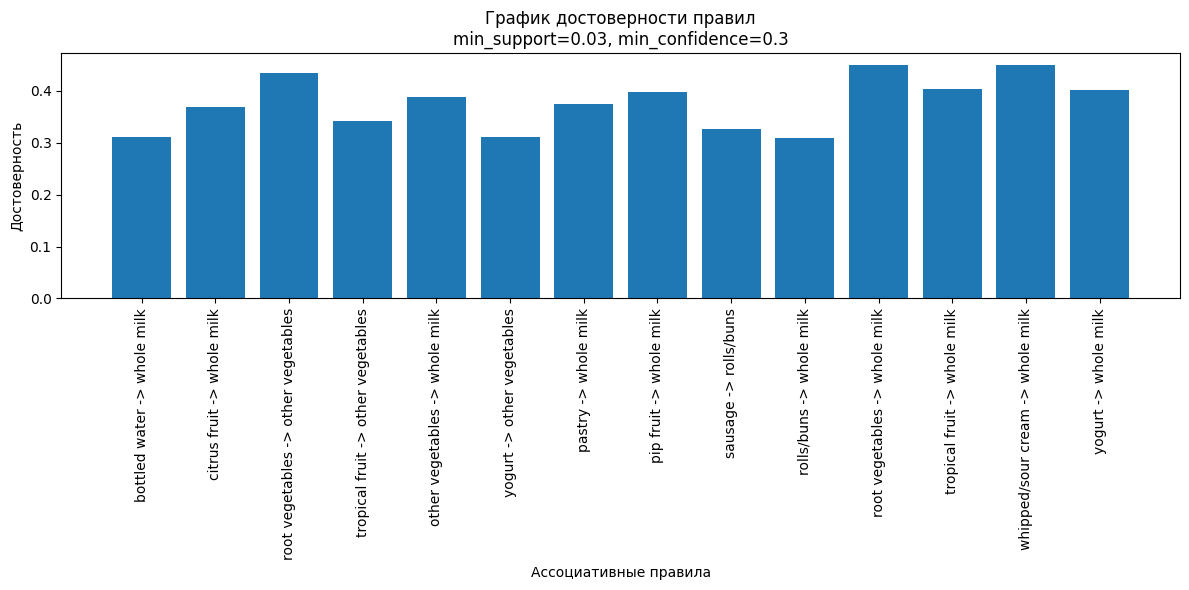

In [61]:
from mlxtend.frequent_patterns import apriori, association_rules
import matplotlib.pyplot as plt

frequent_itemsets = apriori(df, min_support=0.03, use_colnames=True)
rules = association_rules(frequent_itemsets, metric="confidence", min_threshold=0.3)

rules['antecedents'] = rules['antecedents'].apply(lambda x: ', '.join(list(x)))
rules['consequents'] = rules['consequents'].apply(lambda x: ', '.join(list(x)))

products_1 = rules["antecedents"].tolist()
products_2 = rules["consequents"].tolist()
confidence_vals = rules["confidence"].tolist()
rules_labels = [f"{p1} -> {p2}" for p1, p2 in zip(products_1, products_2)]

plt.figure(figsize=(12, 6))
plt.bar(rules_labels, confidence_vals)
plt.xlabel("Ассоциативные правила")
plt.ylabel("Достоверность")
plt.title("График достоверности правил\nmin_support=0.03, min_confidence=0.3")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


<h3>Проанализировать получающийся в результате работы программы граф. Объяснить, какую информацию можно из него извлечь.</h3>

C:\Users\vaind\AppData\Local\Temp\ipykernel_32052\654604666.py:20: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


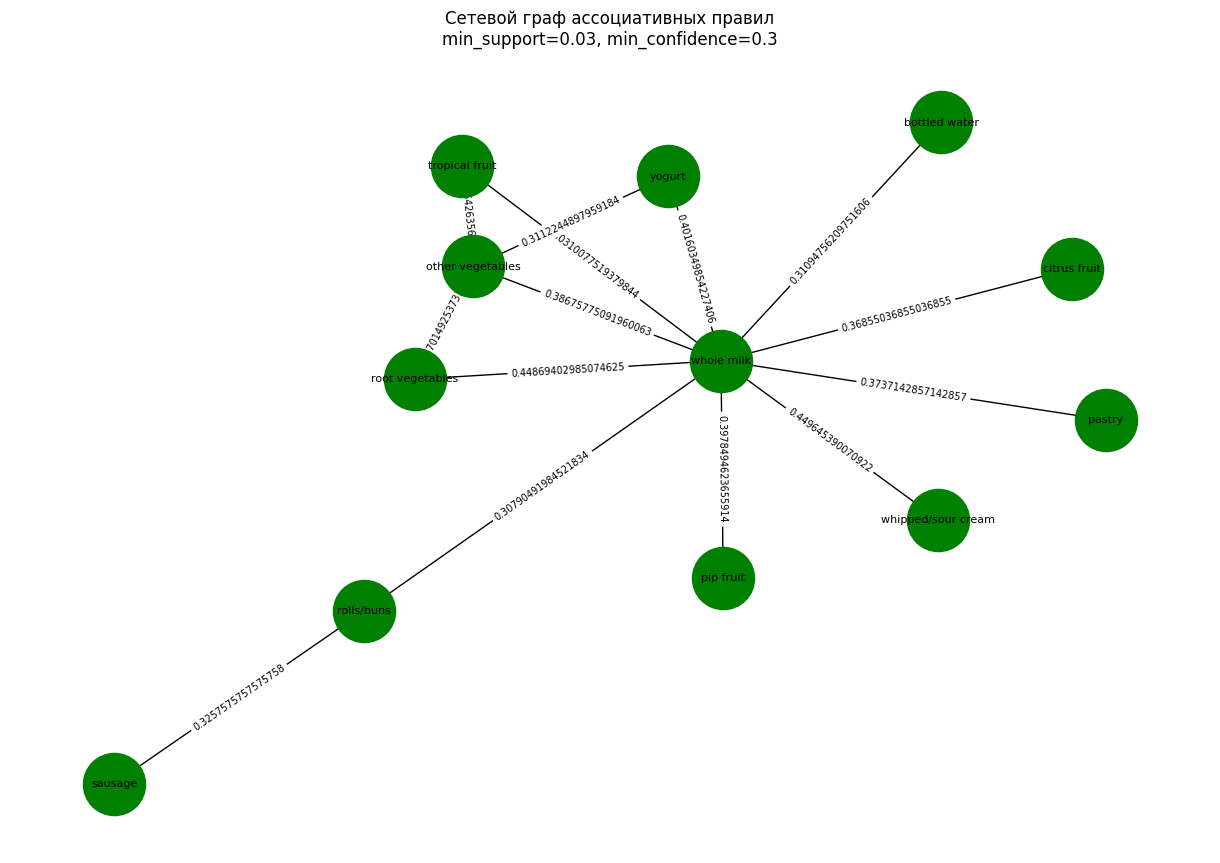

In [63]:
G = nx.Graph()

for product in rules["antecedents"]:
    G.add_node(product)
for product in rules["consequents"]:
    G.add_node(product)

for index, row in rules.iterrows():
    G.add_edge(row['antecedents'], row['consequents'], weight=row['confidence'])

pos = nx.spring_layout(G, seed=42)

plt.figure(figsize=(12, 8))
nx.draw(G, pos, with_labels=True, node_size=2000, node_color='green', font_size=8)

edge_labels = nx.get_edge_attributes(G, 'weight')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=7)

plt.title('Сетевой граф ассоциативных правил\nmin_support=0.03, min_confidence=0.3')
plt.tight_layout()
plt.show()

<h3>Предложить и реализовать свой способ визуализации ассоциативных правил и метрик.</h3>

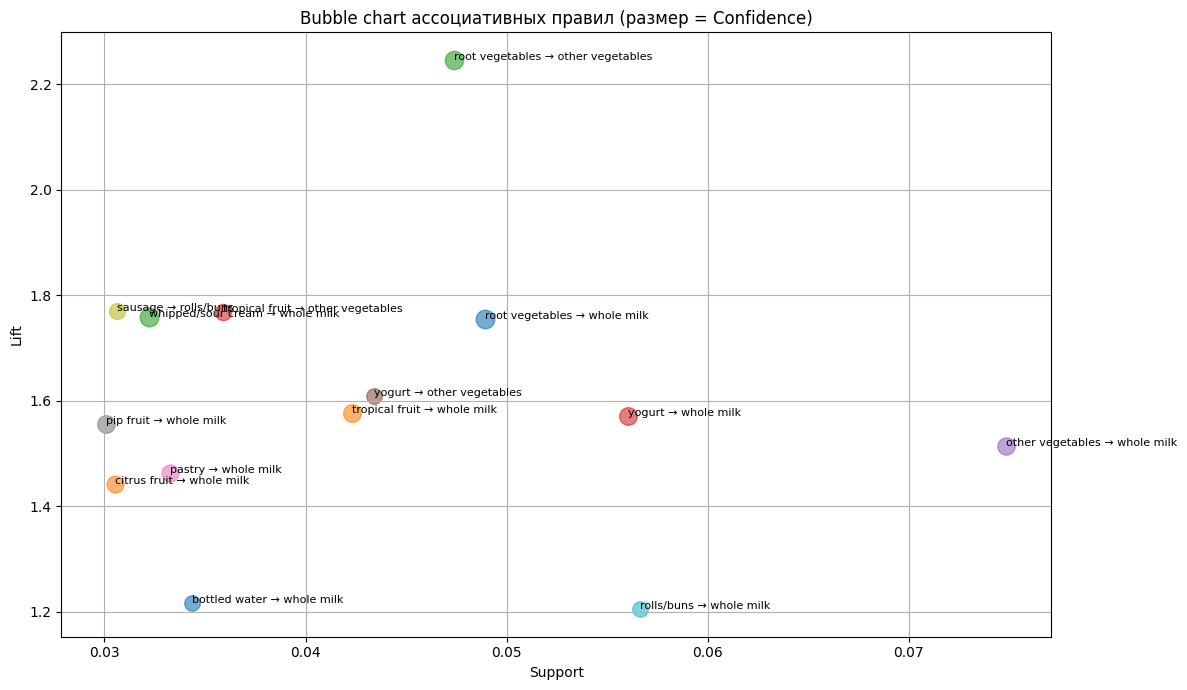

In [68]:
plt.figure(figsize=(12, 7))

for i in range(len(rules)):
    antecedents = (
        ', '.join(list(rules.iloc[i]['antecedents']))
        if isinstance(rules.iloc[i]['antecedents'], (set, frozenset))
        else str(rules.iloc[i]['antecedents'])
    )
    consequents = (
        ', '.join(list(rules.iloc[i]['consequents']))
        if isinstance(rules.iloc[i]['consequents'], (set, frozenset))
        else str(rules.iloc[i]['consequents'])
    )

    plt.scatter(rules.iloc[i]['support'], rules.iloc[i]['lift'],
                s=rules.iloc[i]['confidence'] * 400, alpha=0.6)
    plt.text(rules.iloc[i]['support'], rules.iloc[i]['lift'],
             f"{antecedents} → {consequents}", fontsize=8)

plt.xlabel('Support')
plt.ylabel('Lift')
plt.title('Bubble chart ассоциативных правил (размер = Confidence)')
plt.grid(True)
plt.tight_layout()
plt.show()

